# Predicting fantasy points for the player using machine learning.

In this notebook, we're going to go through an machine learning project with the goal of predicting the fantasy point of the player.

## 1. Problem Definition
> How well can we predict the future fantasy point of a player, given their ball by ball match performace and previous examples of how much fantasy points they have accumulated in a match?

## 2. Data
The data is downloaded from the Kaggle IPL Delivery-Level Data with Pitch Info:

https://www.kaggle.com/datasets/darshshah1010/ipl-delivery-level-data-with-pitch-info/data

The data is organized into separate CSV files for easy access and manipulation:

* Ipl match data - enriched.xlsx – Full ball-by-ball data with pitch types
* all_matches_batting_stats.csv – Player-wise batting stats per match
* all_matches_bowling_stats.csv – Player-wise bowling stats per match

**Note:** We are using `Ipl match data - enriched.xlsx` to gather the players performance data and use that data to generate fantasy point per match. SO basically we are have to enrich the data further before using for modelling. 

## 3. Evaluation

The evaluation metric for this model will be the RMSLE (root mean squared log error) between the actual and predicted fantasy point.

Suggestion by chatgpt:
1. Fantasy points have a wide range (some players score 5, others 120).
2. Users care if you rank players correctly (high vs low scorers), not if you’re off by a few raw points.
3. RMSLE ensures your model is “scale-aware” → a 10-point error on a low scorer is worse than on a high scorer.

## 4. Features

Each row represents a single delivery, with detailed metadata including:

* Batter and bowler names
* Runs scored and extras
* Dismissal types and player out
* Pitch type (e.g., spin-friendly, batting-friendly)
* Boundary events
* Venue, city, date, and over number

In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
# import data

df_bbyb_data = pd.read_excel("data/ipl-fantasy-dataset/dataset_2020-2025/Ipl_match_data-enriched.xlsx")
df_batting_stat = pd.read_csv("data/ipl-fantasy-dataset/dataset_2020-2025/all_matches_batting_stats.csv")
df_bowling_stat = pd.read_csv("data/ipl-fantasy-dataset/dataset_2020-2025/all_matches_bowling_stats.csv")

In [3]:
# find the data where dismissal_kind is run out
df_bbyb_data[df_bbyb_data["dismissal_kind"].str.contains("run out", case=False, na=False)].tail()

,match_id,date,inning,batting_team,over,ball,batter,non_striker,bowler,runs_batter,...,player_out,dismissal_kind,fielders_involved,stadium,pitch_type,boundary,grass_cover,moisture,dew_prediction,bounce_and_carry
81553,1426311,2024-05-24,1,Sunrisers Hyderabad,20,7,PJ Cummins,JD Unadkat,Avesh Khan,0,...,JD Unadkat,run out,"SV Samson, Avesh Khan","MA Chidambaram Stadium, Chepauk, Chennai",Spin-friendly,NaN,Low,Low,Low,Low
82586,1473440,2025-03-23,2,Chennai Super Kings,19,4,RA Jadeja,R Ravindra,Naman Dhir,0,...,RA Jadeja,run out,"RD Rickelton, DL Chahar","MA Chidambaram Stadium, Chepauk, Chennai",Spin-friendly,NaN,Low,Low,Low,Low
82692,1473441,2025-03-24,1,Lucknow Super Giants,17,4,SN Thakur,DA Miller,Kuldeep Yadav,0,...,SN Thakur,run out,"Abishek Porel, AR Patel",Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...,Balanced,NaN,Medium,Medium,Moderate,Consistent
82829,1473441,2025-03-24,2,Delhi Capitals,19,3,Kuldeep Yadav,Ashutosh Sharma,Prince Yadav,0,...,Kuldeep Yadav,run out,"RR Pant, Prince Yadav",Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket St...,Balanced,NaN,Medium,Medium,Moderate,Consistent
83084,1473442,2025-03-25,2,Gujarat Titans,20,1,SE Rutherford,R Tewatia,Arshdeep Singh,0,...,R Tewatia,run out,Arshdeep Singh,"Narendra Modi Stadium, Ahmedabad",Batting-friendly,NaN,Low,Low,High,True bounce


In [4]:
df_batting_stat.head()

,match_id,date,batter,batting_team,total_runs,times_out,balls_faced
0,1216492,2020-09-19,AT Rayudu,Chennai Super Kings,71,1,49
1,1216492,2020-09-19,F du Plessis,Chennai Super Kings,58,0,45
2,1216492,2020-09-19,HH Pandya,Mumbai Indians,14,1,10
3,1216492,2020-09-19,JJ Bumrah,Mumbai Indians,5,0,3
4,1216492,2020-09-19,JL Pattinson,Mumbai Indians,11,1,8


In [5]:
df_bowling_stat.head()

,match_id,date,bowler,wickets,runs_given,overs_bowled
0,1216492,2020-09-19,DL Chahar,2,31,4
1,1216492,2020-09-19,JJ Bumrah,1,41,4
2,1216492,2020-09-19,JL Pattinson,1,26,4
3,1216492,2020-09-19,KH Pandya,1,36,4
4,1216492,2020-09-19,L Ngidi,3,36,4


In [6]:
df_bbyb_data.columns

Index(['match_id', 'date', 'inning', 'batting_team', 'over', 'ball', 'batter',
       'non_striker', 'bowler', 'runs_batter', 'runs_total', 'extras_type',
       'player_out', 'dismissal_kind', 'fielders_involved', 'stadium',
       'pitch_type', 'boundary', 'grass_cover', 'moisture', 'dew_prediction',
       'bounce_and_carry'],
      dtype='object')

In [7]:
batting_gby = df_bbyb_data.groupby(['match_id', 'batter'])
batting_gby.player_out.value_counts()

match_id  batter          player_out    
1216492   AT Rayudu       AT Rayudu         1
          HH Pandya       HH Pandya         1
          JL Pattinson    JL Pattinson      1
          KA Pollard      KA Pollard        1
          KH Pandya       KH Pandya         1
                                           ..
1473442   P Simran Singh  P Simran Singh    1
          Priyansh Arya   Priyansh Arya     1
          SE Rutherford   R Tewatia         1
                          SE Rutherford     1
          Shubman Gill    Shubman Gill      1
Name: count, Length: 4164, dtype: int64

### Data Creation 

As we have ball by ball data from 2020 till 2025 we can use this information to extract the batting, bowling, fielder performance data along with match details data from which we can generate data file which can be usefull to apply machine learning model 

In [8]:
# Extract batting performance data by batter
batting = df_bbyb_data.groupby(['match_id', 'batter', 'batting_team']).agg(
    runs=('runs_batter', 'sum'),
    balls_faced=('ball', 'count'),
    fours=('runs_batter', lambda x:(x == 4).sum()),
    sixes=('runs_batter', lambda x:(x == 6).sum()),
    is_dismissed=('player_out', 'count'),
    dismissal_kind=('dismissal_kind','sum'),
    inning=('inning', 'mean')
).reset_index()
batting.rename(columns={'batter':'player'}, inplace=True)
batting['strike_rate'] = batting['runs'] / batting['balls_faced'] * 100

batting.head()
                        

,match_id,player,batting_team,runs,balls_faced,fours,sixes,is_dismissed,dismissal_kind,inning,strike_rate
0,1216492,AT Rayudu,Chennai Super Kings,71,49,6,3,1,caught and bowled,2.0,144.897959
1,1216492,F du Plessis,Chennai Super Kings,58,45,6,0,0,0,2.0,128.888889
2,1216492,HH Pandya,Mumbai Indians,14,10,0,2,1,caught,1.0,140.000000
3,1216492,JJ Bumrah,Mumbai Indians,5,3,0,0,0,0,1.0,166.666667
4,1216492,JL Pattinson,Mumbai Indians,11,8,2,0,1,caught,1.0,137.500000


In [9]:
df_bbyb_data.columns

Index(['match_id', 'date', 'inning', 'batting_team', 'over', 'ball', 'batter',
       'non_striker', 'bowler', 'runs_batter', 'runs_total', 'extras_type',
       'player_out', 'dismissal_kind', 'fielders_involved', 'stadium',
       'pitch_type', 'boundary', 'grass_cover', 'moisture', 'dew_prediction',
       'bounce_and_carry'],
      dtype='object')

In [25]:
# Extract bowling performance data by batter
# Find the maiden over delivered by the bowler
maiden_overs = df_bbyb_data.groupby(['match_id', 'bowler', 'over']).agg(
    balls_in_over=('ball', 'count'),
    runs_in_over=('runs_batter', 'sum')
).reset_index()

# Mark maiden overs
maiden_overs['is_maiden'] = (maiden_overs['balls_in_over']==6) & (maiden_overs['runs_in_over']==0)

# Count maidens per bowler
maidens_per_bowler = (
    maiden_overs.groupby(['match_id', 'bowler'])['is_maiden']
    .sum()
    .reset_index(name='maidens')
)

# Extract the other important data for the bowler
bowling = df_bbyb_data.groupby(['match_id', 'bowler']).agg(
    balls_bowled=('ball', 'count'),
    runs_conceded=('runs_batter', 'sum'),
    dot_balls=('runs_batter', lambda x: (x == 0).sum()),
    wickets=('player_out', lambda x:x.notnull().sum())
).reset_index()

bowling['overs'] = bowling['balls_bowled'] // 6
bowling['economy'] = bowling['runs_conceded'] / bowling['overs'].replace(0, 1)

#merge maidens
bowling = bowling.merge(maidens_per_bowler, on=['match_id', 'bowler'], how='left')
bowling['maidens'] = bowling['maidens'].fillna(0).astype(int)
bowling.rename(columns={'bowler':'player'}, inplace=True)
bowling.head()

,match_id,player,balls_bowled,runs_conceded,dot_balls,wickets,overs,economy,maidens
0,1216492,DL Chahar,25,31,8,2,4,7.75,0
1,1216492,JJ Bumrah,26,41,11,1,4,10.25,0
2,1216492,JL Pattinson,25,26,11,1,4,6.50,0
3,1216492,KH Pandya,25,36,3,1,4,9.00,0
4,1216492,L Ngidi,26,36,10,3,4,9.00,0


In [11]:
df_bbyb_data.dismissal_kind.value_counts()

dismissal_kind
caught                   2811
bowled                    640
run out                   263
lbw                       262
caught and bowled         106
stumped                    75
hit wicket                  5
retired hurt                4
retired out                 3
obstructing the field       1
Name: count, dtype: int64

In [12]:
# As per the data is there is a run out without direct throw then there are multiple players involved and they are seperated by comma.

# Check if mulitple player involved in run out
df_bbyb_data['runout_type'] = df_bbyb_data.apply(
    lambda row: 'direct' if (row['dismissal_kind'] == 'run out' and ',' not in str(row['fielders_involved'])) 
    else ('assist' if row['dismissal_kind'] == 'run out' else None),
    axis=1
)

# 🔹 Step 2: Split multiple fielders into separate rows
df_expanded = df_bbyb_data.assign(
    fielders_involved=df_bbyb_data['fielders_involved'].str.split(',')
).explode('fielders_involved')

# 🔹 Step 3: Clean whitespace (important if "player1, player2" has spaces)
df_expanded['fielders_involved'] = df_expanded['fielders_involved'].str.strip()

fielder = df_expanded.groupby(['match_id', 'fielders_involved']).agg(
    catches=('dismissal_kind', lambda x:x.isin(['caught', 'caught and bowled']).sum()),
    run_outs=('dismissal_kind', lambda x:(x == 'run out').sum()),
    direct_run_out=('runout_type', lambda x:(x == "direct").sum())
).reset_index()
fielder.rename(columns={'fielders_involved':'player'}, inplace=True)

fielder

,match_id,player,catches,run_outs,direct_run_out
0,1216492,F du Plessis,3,0,0
1,1216492,JL Pattinson,1,0,0
2,1216492,MS Dhoni,2,0,0
3,1216492,SM Curran,2,0,0
4,1216492,SR Watson,1,0,0
...,...,...,...,...,...
2470,1473442,Arshad Khan,3,0,0
2471,1473442,Arshdeep Singh,0,1,1
2472,1473442,B Sai Sudharsan,1,0,0
2473,1473442,Priyansh Arya,1,0,0


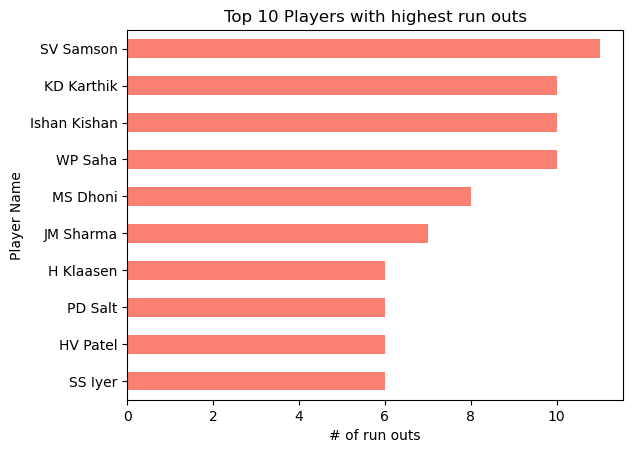

In [13]:
fielding_players = fielder.groupby("player")["run_outs"].sum().sort_values(ascending=False).head(10)
fielding_players.plot(kind='barh', color='salmon')
plt.title("Top 10 Players with highest run outs")
plt.xlabel("# of run outs")
plt.ylabel("Player Name")
plt.gca().invert_yaxis()

In [14]:
df_bbyb_data.head().T

,0,1,2,3,4
match_id,1216492,1216492,1216492,1216492,1216492
date,2020-09-19,2020-09-19,2020-09-19,2020-09-19,2020-09-19
inning,1,1,1,1,1
batting_team,Mumbai Indians,Mumbai Indians,Mumbai Indians,Mumbai Indians,Mumbai Indians
over,1,1,1,1,1
ball,1,2,3,4,5
batter,RG Sharma,RG Sharma,Q de Kock,Q de Kock,Q de Kock
non_striker,Q de Kock,Q de Kock,RG Sharma,RG Sharma,RG Sharma
bowler,DL Chahar,DL Chahar,DL Chahar,DL Chahar,DL Chahar
runs_batter,4,1,2,4,0


In [15]:
matches_subset = df_bbyb_data[['match_id','date','stadium','pitch_type', 'grass_cover', 'moisture', 'dew_prediction', 'bounce_and_carry']].drop_duplicates()
matches_subset.head()

,match_id,date,stadium,pitch_type,grass_cover,moisture,dew_prediction,bounce_and_carry
0,1216492,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish
244,1216493,2020-09-20,Dubai International Cricket Stadium,Balanced,Medium,Low,High,True bounce
500,1216494,2020-10-21,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish
705,1216495,2020-11-03,Sharjah Cricket Stadium,Batting-friendly,Low,Low,Moderate,Low
932,1216496,2020-09-22,Sharjah Cricket Stadium,Batting-friendly,Low,Low,Moderate,Low


In [16]:
bowler_batter_merge = pd.merge(batting, bowling, on=['match_id', 'player'], how='outer').fillna(0)
player_match_stats = pd.merge(bowler_batter_merge, fielder, on=['match_id', 'player'], how='outer').fillna(0)

In [17]:
player_match_stats.head()

,match_id,player,batting_team,runs,balls_faced,fours,sixes,is_dismissed,dismissal_kind,inning,...,balls_bowled,runs_conceded,dot_balls,wickets,overs,economy,maidens,catches,run_outs,direct_run_out
0,1216492,AT Rayudu,Chennai Super Kings,71.0,49.0,6.0,3.0,1.0,caught and bowled,2.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,1216492,DL Chahar,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,25.0,31.0,8.0,2.0,4.0,7.75,0.0,0.0,0.0,0.0
2,1216492,F du Plessis,Chennai Super Kings,58.0,45.0,6.0,0.0,0.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3.0,0.0,0.0
3,1216492,HH Pandya,Mumbai Indians,14.0,10.0,0.0,2.0,1.0,caught,1.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,1216492,JJ Bumrah,Mumbai Indians,5.0,3.0,0.0,0.0,0.0,0,1.0,...,26.0,41.0,11.0,1.0,4.0,10.25,0.0,0.0,0.0,0.0


In [18]:
df_ipl_data = pd.merge(player_match_stats, matches_subset, on='match_id', how='left')

In [19]:
df_ipl_data.head()

,match_id,player,batting_team,runs,balls_faced,fours,sixes,is_dismissed,dismissal_kind,inning,...,catches,run_outs,direct_run_out,date,stadium,pitch_type,grass_cover,moisture,dew_prediction,bounce_and_carry
0,1216492,AT Rayudu,Chennai Super Kings,71.0,49.0,6.0,3.0,1.0,caught and bowled,2.0,...,0.0,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish
1,1216492,DL Chahar,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish
2,1216492,F du Plessis,Chennai Super Kings,58.0,45.0,6.0,0.0,0.0,0,2.0,...,3.0,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish
3,1216492,HH Pandya,Mumbai Indians,14.0,10.0,0.0,2.0,1.0,caught,1.0,...,0.0,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish
4,1216492,JJ Bumrah,Mumbai Indians,5.0,3.0,0.0,0.0,0.0,0,1.0,...,0.0,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish


In [26]:
def calculate_fantasy_points(row):
    points = 0
    
    # --- Batting ---
    points += row['runs'] * 1
    points += row['fours'] * 4
    points += row['sixes'] * 6
    
    if row['runs'] >= 50:
        points += 8
    if row['runs'] >= 75:
        points += 12
    if row['runs'] >= 100:
        points += 16
    if row['runs'] == 0 and row['balls_faced'] > 0 and row['is_dismissed']:
        points -= 2
    
    # Strike rate (if >=10 balls faced)
    if row['balls_faced'] >= 10:
        sr = row['strike_rate']
        if 170 <= sr :
            points += 6
        elif 150 <= sr < 170:
            points += 4
        elif 130 <= sr < 150:
            points += 2
        elif 60 <= sr < 70:
            points -= 2
        elif 50 <= sr < 60:
            points -= 4
        elif sr < 50:
            points -= 6
    
    # --- Bowling ---
    #TODO add dot balls : dot_ball*1
    points += row['wickets'] * 30
    if row['wickets'] >= 3:
        points += 4
    if row['wickets'] >= 4:
        points += 8
    if row['wickets'] >= 5:
        points += 12
    points += row['maidens'] * 12
    points += row['dot_balls'] * 1
    
    if row['overs'] >= 2:  # economy bonus/penalty
        eco = row['economy']
        if eco < 5:
            points += 6
        elif 5 <= eco < 6:
            points += 4
        elif 6 <= eco < 7:
            points += 2
        elif 10 <= eco < 11:
            points -= 2
        elif 11 <= eco < 12:
            points -= 4
        elif eco >= 12:
            points -= 6
    
    # --- Fielding ---
    points += row['catches'] * 8
    if row['catches'] >=3 :
        points += 3
    
    points += row['stumpings'] * 12 if 'stumpings' in row else 0
    #TODO run_out_directhit 12 and run_out_not_direct_hit 6
    points += row['run_outs'] * 6  # adjust if you separate direct vs assist
    
    return points

In [27]:
df_ipl_data['fantasy_points'] = df_ipl_data.apply(calculate_fantasy_points, axis=1)
df_ipl_data[:100]

,match_id,player,batting_team,runs,balls_faced,fours,sixes,is_dismissed,dismissal_kind,inning,...,run_outs,direct_run_out,date,stadium,pitch_type,grass_cover,moisture,dew_prediction,bounce_and_carry,fantasy_points
0,1216492,AT Rayudu,Chennai Super Kings,71.0,49.0,6.0,3.0,1.0,caught and bowled,2.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,123.0
1,1216492,DL Chahar,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,68.0
2,1216492,F du Plessis,Chennai Super Kings,58.0,45.0,6.0,0.0,0.0,0,2.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,117.0
3,1216492,HH Pandya,Mumbai Indians,14.0,10.0,0.0,2.0,1.0,caught,1.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,28.0
4,1216492,JJ Bumrah,Mumbai Indians,5.0,3.0,0.0,0.0,0.0,0,1.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1216496,R Tewatia,Rajasthan Royals,10.0,8.0,1.0,0.0,1.0,lbw,1.0,...,0.0,0.0,2020-09-22,Sharjah Cricket Stadium,Batting-friendly,Low,Low,Moderate,Low,115.0
96,1216496,RA Jadeja,Chennai Super Kings,1.0,2.0,0.0,0.0,0.0,0,2.0,...,0.0,0.0,2020-09-22,Sharjah Cricket Stadium,Batting-friendly,Low,Low,Moderate,Low,9.0
97,1216496,RD Gaikwad,Chennai Super Kings,0.0,1.0,0.0,0.0,1.0,stumped,2.0,...,0.0,0.0,2020-09-22,Sharjah Cricket Stadium,Batting-friendly,Low,Low,Moderate,Low,-2.0
98,1216496,RV Uthappa,Rajasthan Royals,5.0,9.0,0.0,0.0,1.0,caught,1.0,...,0.0,0.0,2020-09-22,Sharjah Cricket Stadium,Batting-friendly,Low,Low,Moderate,Low,5.0


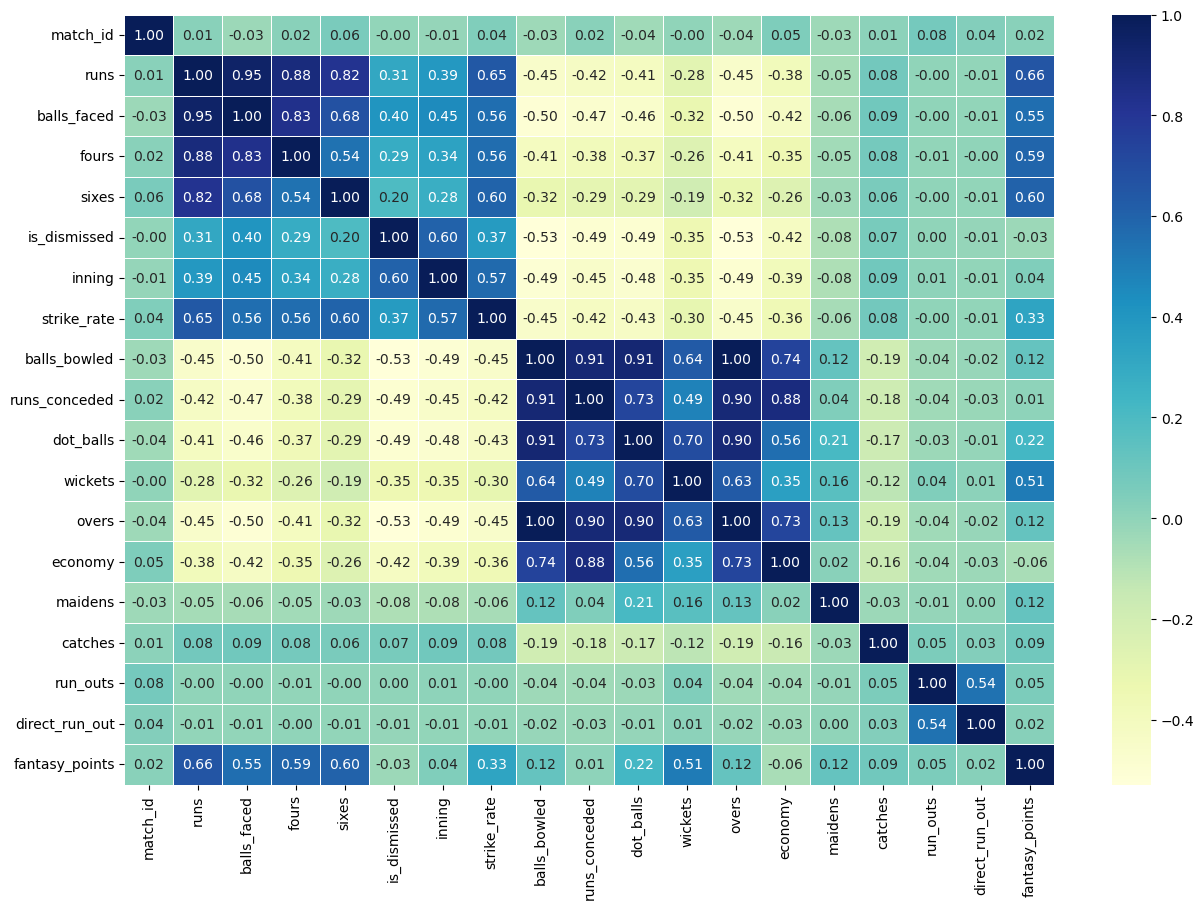

In [28]:
df_ipl_num_data = df_ipl_data.select_dtypes(include='number')

corr_matrix = df_ipl_num_data.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu");

In [23]:
pd.crosstab(df_ipl_data.runs, df_ipl_data.fantasy_points)

fantasy_points,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,...,249.0,252.0,258.0,259.0,261.0,272.0,278.0,284.0,290.0,309.0
runs,,,,,,,,,,,,,,,,,,,,,
0.0,10,0,121,0,61,0,279,0,285,0,...,0,0,0,0,0,0,0,0,0,0
1.0,0,0,0,13,0,3,0,5,0,113,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,15,0,4,0,3,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,1,0,11,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,1,0,0,0,9,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
124.0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
129.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [24]:
df_ipl_data.groupby(['match_id', 'batting_team']).head()

,match_id,player,batting_team,runs,balls_faced,fours,sixes,is_dismissed,dismissal_kind,inning,...,run_outs,direct_run_out,date,stadium,pitch_type,grass_cover,moisture,dew_prediction,bounce_and_carry,fantasy_points
0,1216492,AT Rayudu,Chennai Super Kings,71.0,49.0,6.0,3.0,1.0,caught and bowled,2.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,123.0
1,1216492,DL Chahar,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,60.0
2,1216492,F du Plessis,Chennai Super Kings,58.0,45.0,6.0,0.0,0.0,0,2.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,117.0
3,1216492,HH Pandya,Mumbai Indians,14.0,10.0,0.0,2.0,1.0,caught,1.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,28.0
4,1216492,JJ Bumrah,Mumbai Indians,5.0,3.0,0.0,0.0,0.0,0,1.0,...,0.0,0.0,2020-09-19,Sheikh Zayed Stadium,Sluggish,Low,Low,High,Sluggish,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7757,1473442,MP Stoinis,Punjab Kings,20.0,16.0,1.0,2.0,1.0,caught,1.0,...,0.0,0.0,2025-03-25,"Narendra Modi Stadium, Ahmedabad",Batting-friendly,Low,Low,High,True bounce,30.0
7758,1473442,Mohammed Siraj,0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,2025-03-25,"Narendra Modi Stadium, Ahmedabad",Batting-friendly,Low,Low,High,True bounce,-6.0
7759,1473442,P Simran Singh,Punjab Kings,5.0,8.0,1.0,0.0,1.0,caught,1.0,...,0.0,0.0,2025-03-25,"Narendra Modi Stadium, Ahmedabad",Batting-friendly,Low,Low,High,True bounce,9.0
7760,1473442,Priyansh Arya,Punjab Kings,47.0,24.0,7.0,2.0,1.0,caught,1.0,...,0.0,0.0,2025-03-25,"Narendra Modi Stadium, Ahmedabad",Batting-friendly,Low,Low,High,True bounce,101.0


### Save enriched datafile as scv 

In [53]:
# Saving enriched data with fantasy points as a csv file 
df_ipl_data.to_csv("data/ipl-fantasy-dataset/dataset_2020-2025/enriched_ipl_data_with_fantasy_points.csv")

### Make a copy of the original Dataframe
We make a copy of the original dataframe so when we manipulate the copy, we've still got out original data.

In [69]:
# Read the data ccv
df = pd.read_csv('data/ipl-fantasy-dataset/dataset_2020-2025/enriched_ipl_data_with_fantasy_points.csv')

# Make a copy
df_tmp = df.copy()

df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7770 entries, 0 to 7769
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7770 non-null   int64  
 1   match_id          7770 non-null   int64  
 2   player            7770 non-null   object 
 3   batting_team      7770 non-null   object 
 4   runs              7770 non-null   float64
 5   balls_faced       7770 non-null   float64
 6   fours             7770 non-null   float64
 7   sixes             7770 non-null   float64
 8   is_dismissed      7770 non-null   float64
 9   dismissal_kind    7770 non-null   object 
 10  inning            7770 non-null   float64
 11  strike_rate       7770 non-null   float64
 12  balls_bowled      7770 non-null   float64
 13  runs_conceded     7770 non-null   float64
 14  dot_balls         7770 non-null   float64
 15  wickets           7770 non-null   float64
 16  overs             7770 non-null   float64


In [70]:
### Covert date column to datetime type from object
df_tmp["date"] = df_tmp["date"].astype("datetime64[ns]")

df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7770 entries, 0 to 7769
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        7770 non-null   int64         
 1   match_id          7770 non-null   int64         
 2   player            7770 non-null   object        
 3   batting_team      7770 non-null   object        
 4   runs              7770 non-null   float64       
 5   balls_faced       7770 non-null   float64       
 6   fours             7770 non-null   float64       
 7   sixes             7770 non-null   float64       
 8   is_dismissed      7770 non-null   float64       
 9   dismissal_kind    7770 non-null   object        
 10  inning            7770 non-null   float64       
 11  strike_rate       7770 non-null   float64       
 12  balls_bowled      7770 non-null   float64       
 13  runs_conceded     7770 non-null   float64       
 14  dot_balls         7770 n

### Add datetime parameters for `date` column

In [71]:
df_tmp["matchYear"] = df_tmp.date.dt.year
df_tmp["matchMonth"] = df_tmp.date.dt.month
df_tmp["matchDay"] = df_tmp.date.dt.day
df_tmp["matchDayOfWeek"] = df_tmp.date.dt.dayofweek
df_tmp["matchDayOfYear"] = df_tmp.date.dt.dayofyear

### Sort Dataframe by saledate

When working with timeseries data. it's good idea to sort it by date

In [73]:
# Sort Dataframe in date order
df_tmp.sort_values(by=["date"], inplace=True, ascending=True)
df_tmp.date.head(20)

0    2020-09-19
5    2020-09-19
8    2020-09-19
7    2020-09-19
6    2020-09-19
1    2020-09-19
3    2020-09-19
2    2020-09-19
10   2020-09-19
9    2020-09-19
4    2020-09-19
11   2020-09-19
12   2020-09-19
13   2020-09-19
14   2020-09-19
16   2020-09-19
17   2020-09-19
18   2020-09-19
19   2020-09-19
20   2020-09-19
Name: date, dtype: datetime64[ns]

In [74]:
df_tmp.columns

Index(['Unnamed: 0', 'match_id', 'player', 'batting_team', 'runs',
       'balls_faced', 'fours', 'sixes', 'is_dismissed', 'dismissal_kind',
       'inning', 'strike_rate', 'balls_bowled', 'runs_conceded', 'dot_balls',
       'wickets', 'overs', 'economy', 'maidens', 'catches', 'run_outs',
       'direct_run_out', 'date', 'stadium', 'pitch_type', 'grass_cover',
       'moisture', 'dew_prediction', 'bounce_and_carry', 'fantasy_points',
       'matchYear', 'matchMonth', 'matchDay', 'matchDayOfWeek',
       'matchDayOfYear'],
      dtype='object')

In [75]:
# Now we've enriched out DataFrame with date time features, we can remove date column

df_tmp.drop("date", axis=1, inplace=True)


In [76]:
df_tmp.head()

,Unnamed: 0,match_id,player,batting_team,runs,balls_faced,fours,sixes,is_dismissed,dismissal_kind,...,grass_cover,moisture,dew_prediction,bounce_and_carry,fantasy_points,matchYear,matchMonth,matchDay,matchDayOfWeek,matchDayOfYear
0,0,1216492,AT Rayudu,Chennai Super Kings,71.0,49.0,6.0,3.0,1.0,caught and bowled,...,Low,Low,High,Sluggish,123.0,2020,9,19,5,263
5,5,1216492,JL Pattinson,Mumbai Indians,11.0,8.0,2.0,0.0,1.0,caught,...,Low,Low,High,Sluggish,70.0,2020,9,19,5,263
8,8,1216492,L Ngidi,0,0.0,0.0,0.0,0.0,0.0,0,...,Low,Low,High,Sluggish,104.0,2020,9,19,5,263
7,7,1216492,KH Pandya,Mumbai Indians,3.0,3.0,0.0,0.0,1.0,caught,...,Low,Low,High,Sluggish,36.0,2020,9,19,5,263
6,6,1216492,KA Pollard,Mumbai Indians,18.0,14.0,1.0,1.0,1.0,caught,...,Low,Low,High,Sluggish,28.0,2020,9,19,5,263


## 5. Modelling

We've done enough EDA(We could alway do more) but let's start to do some model-driven EDA

In [77]:
# Let's build a machine leraning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)

model.fit(df_tmp.drop("fantasy_points", axis=1), df_tmp["fantasy_points"])

ValueError: could not convert string to float: 'AT Rayudu'

In [78]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7769
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7770 non-null   int64  
 1   match_id          7770 non-null   int64  
 2   player            7770 non-null   object 
 3   batting_team      7770 non-null   object 
 4   runs              7770 non-null   float64
 5   balls_faced       7770 non-null   float64
 6   fours             7770 non-null   float64
 7   sixes             7770 non-null   float64
 8   is_dismissed      7770 non-null   float64
 9   dismissal_kind    7770 non-null   object 
 10  inning            7770 non-null   float64
 11  strike_rate       7770 non-null   float64
 12  balls_bowled      7770 non-null   float64
 13  runs_conceded     7770 non-null   float64
 14  dot_balls         7770 non-null   float64
 15  wickets           7770 non-null   float64
 16  overs             7770 non-null   float64
 17  

In [63]:
df_tmp.isna().sum()

Unnamed: 0          0
match_id            0
player              0
batting_team        0
runs                0
balls_faced         0
fours               0
sixes               0
is_dismissed        0
dismissal_kind      0
inning              0
strike_rate         0
balls_bowled        0
runs_conceded       0
dot_balls           0
wickets             0
overs               0
economy             0
maidens             0
catches             0
run_outs            0
direct_run_out      0
stadium             0
pitch_type          0
grass_cover         0
moisture            0
dew_prediction      0
bounce_and_carry    0
fantasy_points      0
dtype: int64

### Convert string to categories

One way we can turn all our data into numbers is by converting them into pandas categories.

We can check the different datatypes compatible with pandas here: https://pandas.pydata.org/pandas-docs/version/1.4/reference/general_utility_functions.html#data-types-related-functionality

In [79]:
# Find the columng which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

player
batting_team
dismissal_kind
stadium
pitch_type
grass_cover
moisture
dew_prediction
bounce_and_carry


In [80]:
# Find the columng which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

player
batting_team
dismissal_kind
stadium
pitch_type
grass_cover
moisture
dew_prediction
bounce_and_carry


In [81]:
# This will turn all of the string value into category values
df_tmp = df_tmp.astype({col: "category" for col in df_tmp.select_dtypes(include="object").columns})

In [82]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7770 entries, 0 to 7769
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Unnamed: 0        7770 non-null   int64   
 1   match_id          7770 non-null   int64   
 2   player            7770 non-null   category
 3   batting_team      7770 non-null   category
 4   runs              7770 non-null   float64 
 5   balls_faced       7770 non-null   float64 
 6   fours             7770 non-null   float64 
 7   sixes             7770 non-null   float64 
 8   is_dismissed      7770 non-null   float64 
 9   dismissal_kind    7770 non-null   category
 10  inning            7770 non-null   float64 
 11  strike_rate       7770 non-null   float64 
 12  balls_bowled      7770 non-null   float64 
 13  runs_conceded     7770 non-null   float64 
 14  dot_balls         7770 non-null   float64 
 15  wickets           7770 non-null   float64 
 16  overs             7770 non-nu

In [83]:
df_tmp.columns

Index(['Unnamed: 0', 'match_id', 'player', 'batting_team', 'runs',
       'balls_faced', 'fours', 'sixes', 'is_dismissed', 'dismissal_kind',
       'inning', 'strike_rate', 'balls_bowled', 'runs_conceded', 'dot_balls',
       'wickets', 'overs', 'economy', 'maidens', 'catches', 'run_outs',
       'direct_run_out', 'stadium', 'pitch_type', 'grass_cover', 'moisture',
       'dew_prediction', 'bounce_and_carry', 'fantasy_points', 'matchYear',
       'matchMonth', 'matchDay', 'matchDayOfWeek', 'matchDayOfYear'],
      dtype='object')

### Save preprocessed data

In [84]:
# Export current tmp dataframe
df_tmp.to_csv("data/ipl-fantasy-dataset/dataset_2020-2025/ipl_data_enriched_tmp.csv",
             index=False)

In [86]:
# Import preprocesed dataframe
df_tmp = pd.read_csv("data/ipl-fantasy-dataset/dataset_2020-2025/ipl_data_enriched_tmp.csv",
                 low_memory=False)

In [96]:
df_tmp['matchYear']

0       2020
1       2020
2       2020
3       2020
4       2020
        ... 
7765    2025
7766    2025
7767    2025
7768    2025
7769    2025
Name: matchYear, Length: 7770, dtype: int64

In [88]:
## Filling and tuning categorical variables into numbers

In [89]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

player
batting_team
dismissal_kind
stadium
pitch_type
grass_cover
moisture
dew_prediction
bounce_and_carry


In [91]:
# Turn catecorical variables into number and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [92]:
pd.Categorical(df_tmp["player"]).codes

array([ 23, 121, 157, ..., 188, 115, 362], shape=(7770,), dtype=int16)

Now that all of data is number as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [93]:
%%time
# Instantiate model 
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)

# Fit the model
model.fit(df_tmp.drop("fantasy_points", axis=1), df_tmp["fantasy_points"])

CPU times: user 5.95 s, sys: 55.7 ms, total: 6 s
Wall time: 710 ms


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [94]:
# Score the model
model.score(df_tmp.drop("fantasy_points", axis=1), df_tmp["fantasy_points"])

0.9986650853181532

### Splitting data into train/validation sets

In [98]:
# split data into training and testing
df_val = df_tmp[df_tmp.matchYear == 2025]
df_train = df_tmp[df_tmp.matchYear != 2025]

len(df_val), len(df_train)

(119, 7651)

In [99]:
# Split data into X & y

X_train, y_train = df_train.drop("fantasy_points", axis=1), df_train.fantasy_points
X_valid, y_valid = df_val.drop("fantasy_points", axis=1), df_val.fantasy_points

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((7651, 42), (7651,), (119, 42), (119,))

### Building an evaluation function

In [109]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_test, y_preds):
    """
    Calculate root mean squared error between predictions and true labels.
    """
    return np.sqrt(mean_squared_error(y_test, y_preds))

# Create function to evalute model on few different levels
def show_scores(model) :
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
             "Valid MAE": mean_absolute_error(y_valid, val_preds),
             "Training RMSE": rmse(y_train, train_preds),
             "Valid RMSE": rmse(y_valid, val_preds),
             "Traiining R^2": r2_score(y_train, train_preds),
             "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

In [110]:
%%time
# Instantiate model 
model = RandomForestRegressor(n_jobs=-1,
                             random_state=42)

# Fit the model
model.fit(X_train, y_train)

CPU times: user 5.9 s, sys: 36.1 ms, total: 5.94 s
Wall time: 697 ms


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [111]:
show_scores(model)

{'Training MAE': 0.7956306365181023,
 'Valid MAE': 2.4788235294117644,
 'Training RMSE': np.float64(1.6153822850356363),
 'Valid RMSE': np.float64(4.247091144922288),
 'Traiining R^2': 0.9986714656480408,
 'Valid R^2': 0.9922794431677923}

### Hyperparameter tuning with RandomizedSearchCV

In [115]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RanRandomForestRegressor hyperparameter

rf_grid = {"n_estimators": np.arange(10, 100, 10),
            "max_depth" : [None, 3, 5, 10],
            "min_samples_split": np.arange(2, 20, 2),
            "min_samples_leaf": np.arange(1, 20, 2),
            "max_features": [0.5, 1, "sqrt", "log2"]}

# Instatiate RanRandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                             param_distributions=rf_grid,
                             n_iter=100,
                             cv=5,
                             verbose=True)

# Fit the RanRandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 1min 38s, sys: 5.25 s, total: 1min 43s
Wall time: 31.1 s


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 3, ...], 'max_features': [0.5, 1, ...], 'min_samples_leaf': array([ 1, 3..., 15, 17, 19]), 'min_samples_split': array([ 2, 4..., 14, 16, 18]), ...}"
,n_iter,100
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [116]:
# Find the best model hyperparameters

rs_model.best_params_

{'n_estimators': np.int64(70),
 'min_samples_split': np.int64(8),
 'min_samples_leaf': np.int64(3),
 'max_features': 0.5,
 'max_depth': 10}

In [117]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 2.2136303556054813,
 'Valid MAE': 3.0306290575511663,
 'Training RMSE': np.float64(3.781922779391209),
 'Valid RMSE': np.float64(4.320802201958482),
 'Traiining R^2': 0.9927180537212786,
 'Valid R^2': 0.9920091269186937}

### Train a model with the best hyperparameters
**Note:** These were found after 100 iteration of `RandomizedSearchCV`

In [118]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=70,
                                   min_samples_leaf=3,
                                   min_samples_split=8,
                                   max_features=0.5,
                                   max_depth=10)
# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 1 s, sys: 10.5 ms, total: 1.01 s
Wall time: 1.01 s


,n_estimators,70
,criterion,'squared_error'
,max_depth,10
,min_samples_split,8
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [119]:
# Score for ideal model trained on all the data
show_scores(ideal_model)

{'Training MAE': 2.2097764274738294,
 'Valid MAE': 3.00615403266761,
 'Training RMSE': np.float64(3.742723492517801),
 'Valid RMSE': np.float64(4.3433991202426165),
 'Traiining R^2': 0.9928682248384978,
 'Valid R^2': 0.991925327074379}

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most importance when it comse to predisction the traget variable (SalePrice)

In [120]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([6.63525942e-04, 4.44452431e-04, 8.62208157e-04, 3.02918756e-04,
       3.66823539e-01, 9.95298086e-02, 3.31283525e-02, 5.03621298e-02,
       8.68503218e-05, 2.52925106e-04, 2.03789216e-04, 2.72754691e-02,
       1.64332235e-02, 3.29474807e-03, 6.03031329e-02, 3.15950777e-01,
       6.69783299e-03, 4.48858995e-03, 8.25515080e-04, 8.73324074e-03,
       5.18229392e-04, 9.37771111e-06, 5.36367542e-04, 1.59502167e-04,
       5.78074223e-05, 3.32983137e-05, 1.04948818e-04, 1.64265343e-04,
       9.28211991e-05, 1.00785702e-04, 6.53147612e-04, 3.65320297e-04,
       5.41100116e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [121]:
# helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))

    # Plot the datafram
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")
    ax.invert_yaxis()

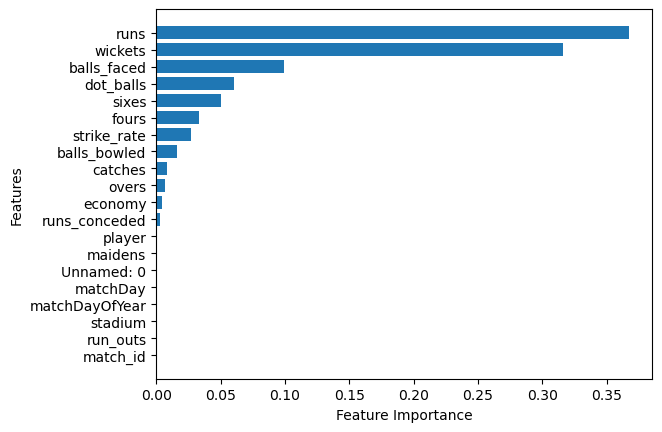

In [122]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [123]:
df_tmp.head().T

,0,1,2,3,4
Unnamed: 0,0,5,8,7,6
match_id,1216492,1216492,1216492,1216492,1216492
player,24,122,158,139,137
batting_team,2,8,1,8,8
runs,71.0,11.0,0.0,3.0,18.0
balls_faced,49.0,8.0,0.0,3.0,14.0
fours,6.0,2.0,0.0,0.0,1.0
sixes,3.0,0.0,0.0,0.0,1.0
is_dismissed,1.0,1.0,0.0,1.0,1.0
dismissal_kind,7,6,1,6,6
